
# Project Overview

Tanzania, with a population of over 57 million, faces significant challenges in providing access to clean water, a fundamental need for its citizens. The country has numerous water points spread across its vast landscape, but many of these wells have deteriorated over time. Some are fully functional, others require repair, and some have failed completely. This project focuses on building a classifier to predict the condition of these water wells, leveraging various data points such as the type of pump used, installation dates, geographic location, and other relevant factors. The outcome of this model will be crucial for organizations like NGOs and the Tanzanian government to prioritize and allocate resources effectively, ensuring better water access for the population.

# Business Understanding

Ensuring the functionality of water wells is critical to providing safe and clean water to communities, particularly in a developing country like Tanzania. The failure of these water points can have severe consequences, leading to water scarcity, poor hygiene, and health issues. For stakeholders such as the Tanzanian government and NGOs, understanding the factors that contribute to the deterioration of wells can drive strategic decisions, such as where to allocate repair resources or how to design more durable wells in the future. This project aims to address this need by developing a predictive model that can classify the condition of wells, enabling these stakeholders to act proactively in maintaining water accessibility.

# Objectives

The overarching goal of this project is to develop a robust and accurate classification model that can predict the condition of water wells in Tanzania. This model will assist in identifying wells that are likely to fail, enabling stakeholders to take preventive measures. By understanding the key factors influencing well functionality, the project will also provide insights that can be used to improve the design and maintenance of future water points. Ultimately, this project seeks to contribute to a more reliable water supply infrastructure in Tanzania, improving the quality of life for its residents.

## Main Objectives

The main objectives of this project include:

1. Analyzing the data to identify the most significant factors contributing to the condition of the wells.
2. Building a predictive model that can classify water wells into one of three categories: functional, in need of repair, or non-functional.
3. Providing actionable insights and recommendations to stakeholders, such as NGOs and the Tanzanian government, to guide their efforts in maintaining and improving water well infrastructure.

## Specific Objectives

To achieve the main objectives, the project will focus on the following specific objectives:

1. Conducting exploratory data analysis (EDA) to uncover patterns and relationships within the data.
2. Developing and fine-tuning a machine learning model for classification to predict well conditions.
3. Evaluating the model's performance using appropriate metrics to ensure accuracy and reliability.
4. Interpreting the model's results to provide clear, actionable recommendations for stakeholders.

# Data Understanding

The dataset for this project comprises detailed information on water wells across Tanzania, including variables such as; the type of pump installed, the year of installation, and the geographic coordinates of each well. Additional features may include the depth of the well, the source of water, and the materials used in construction. Understanding the distribution of these features and their potential impact on well functionality is crucial for building an effective classification model. 

#### Importing the necessary datasets

In [264]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from category_encoders import WOEEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  confusion_matrix, roc_curve, auc, precision_recall_curve, log_loss, matthews_corrcoef, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#### Loading the Datasets

In [265]:
# Import the necessary datasets
df_training_labels = pd.read_csv('Data\Training_Labels.csv', index_col= 0)
df_training_values = pd.read_csv('Data\Training_values.csv', index_col = 0)
df_test_values = pd.read_csv('Data\Test_set.csv', index_col = 0)

#### Inspecting the data

In [266]:
# Getting a preview of the first 5 rows of the training labels data
df_training_labels.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [267]:
# Getting a preview of the first 5 rows of the training values data
df_training_values.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Merging the data

In [268]:
# merging the training values and training labels dataset
df_training_set = df_training_values.merge(df_training_labels, on = "id")

# Getting a preview of the first 5 rows of the merged data
df_training_set.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### Inspecting the merged data

In [269]:
# Getting a summary of the dataset
df_training_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

In [270]:
# Checking the shape of the dataset
df_training_set.shape

(59400, 40)

In [271]:
# Getting the statistics of numerical columns
df_training_set.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# Data Cleaning

Data cleaning is crucial for ensuring the accuracy and reliability of the analysis. This section addresses issues such as dropping irrelevant columns, handling missing values and inconsistencies

#### Dropping columns with information that is not relevant to prediction

In [272]:
# Identify columns with similar information
similar_columns = {
    'extraction_type': ['extraction_type_group', 'extraction_type_class'],
    'management': ['management_group'],
    'payment': ['payment_type'],
    'water_quality': ['quality_group'],
    'quantity': ['quantity_group'],
    'source': ['source_type', 'source_class'],
    'waterpoint_type': ['waterpoint_type_group']
}

# Drop the redundant columns, retaining only the first column of each group
columns_to_drop = [col for group in similar_columns.values() for col in group]
df_training_set = df_training_set.drop(columns=columns_to_drop)

# Dropping columns with information that is not relevant for prediction
df_training_set = df_training_set.drop(columns=['wpt_name','subvillage','num_private', 'recorded_by'])

# Display the shape of the resultant dataframe
df_training_set.shape

(59400, 27)

#### Handling Missing Data 

In [273]:
# Checking for missing values
total_values = 59400
missing_values = df_training_set.isnull().sum()

# Getting the percentage of missing values in each column
missing_percentage = (missing_values/total_values)*100
missing_percentage

amount_tsh            0.000000
date_recorded         0.000000
funder                6.122896
gps_height            0.000000
installer             6.153199
longitude             0.000000
latitude              0.000000
basin                 0.000000
region                0.000000
region_code           0.000000
district_code         0.000000
lga                   0.000000
ward                  0.000000
population            0.000000
public_meeting        5.612795
scheme_management     6.528620
scheme_name          48.501684
permit                5.144781
construction_year     0.000000
extraction_type       0.000000
management            0.000000
payment               0.000000
water_quality         0.000000
quantity              0.000000
source                0.000000
waterpoint_type       0.000000
status_group          0.000000
dtype: float64

In [274]:
# Dropping columns where the percentange of missing values is more than 20
columns_to_drop = missing_percentage[missing_percentage > 20].index
df_training_set = df_training_set.drop(columns=columns_to_drop)

# Impute specific columns with 'Unknown'
df_training_set[['scheme_management', 'funder', 'installer']] = df_training_set[['scheme_management', 'funder', 'installer']].fillna('Unknown')

# Create imputers for numerical and categorical features
numerical_imputer = SimpleImputer(strategy='median')  # For numerical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns

# Impute numerical features
df_training_set[['population']] = numerical_imputer.fit_transform(df_training_set[['population']])

# Impute categorical features
df_training_set[['permit', 'public_meeting']] = categorical_imputer.fit_transform(df_training_set[['permit', 'public_meeting']])

# Checking for missing values
df_training_set.isnull().sum()

amount_tsh           0
date_recorded        0
funder               0
gps_height           0
installer            0
longitude            0
latitude             0
basin                0
region               0
region_code          0
district_code        0
lga                  0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment              0
water_quality        0
quantity             0
source               0
waterpoint_type      0
status_group         0
dtype: int64

#### Checking for duplicates

In [275]:
# Identify duplicated index values
duplicated_index = df_training_set.index.duplicated()

# Display the rows with duplicated index values
duplicate_rows = df_training_set[duplicated_index]
duplicate_rows

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,,


#### Converting Datatypes

In [276]:
# Checking data types
df_training_set.dtypes

amount_tsh           float64
date_recorded         object
funder                object
gps_height             int64
installer             object
longitude            float64
latitude             float64
basin                 object
region                object
region_code            int64
district_code          int64
lga                   object
ward                  object
population           float64
public_meeting        object
scheme_management     object
permit                object
construction_year      int64
extraction_type       object
management            object
payment               object
water_quality         object
quantity              object
source                object
waterpoint_type       object
status_group          object
dtype: object

In [277]:
# Fixing the datatypes
df_training_set['date_recorded'] = pd.to_datetime(df_training_set['date_recorded'], format='%d/%m/%Y')

#### Fixing Spelling mistakes in the installer column

In [278]:
df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('District Water Department', 'District water depar', 'Distric Water Department'),value='District water department')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('FinW', 'Fini water', 'FINI WATER'), value='Fini Water')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace='JAICA',value='Jaica')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('COUN', 'District COUNCIL', 'DISTRICT COUNCIL', 'District Counci','District Council', 'Council', 'Counc', 'District  Council', 'Distri'),value='District council')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('RC CHURCH', 'RC Churc', 'RC', 'RC Ch', 'RC C', 'RC CH', 'RC church','RC CATHORIC'),value='RC Church')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Central Government', 'Tanzania Government','central government', 'Cental Government', 'Cebtral Government','Tanzanian Government', 'Tanzania government', 'Centra Government','CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT', 'Central govt', 'Centr','Centra govt'), value='Central government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('World vision', 'World Division', 'World Vision'),value='world vision')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Unisef', 'UNICEF'),value='Unicef')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace='DANID',value='DANIDA')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi','Village Council', 'Village Counil', 'Villages', 'Vill', 'Village community', 'Villaers', 'Village Community', 'Villag', 'Villege Council', 'Village council','Village  Council', 'Villagerd', 'Villager', 'Village Technician','Village Office', 'Village community members'),value='villagers')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Commu', 'Communit', 'commu', 'COMMU', 'COMMUNITY'),value='Community')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM', 'GOVERN', 'Gover', 'Gove','Governme', 'Governmen'),value='Government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace='Hesawa',value='HESAWA')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Colonial Government'),value='Colonial government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Government of Misri'),value='Misri Government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Italy government'),value='Italian government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('British colonial government'),value='British government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Concern /government'),value='Concern/Government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Village Government'),value='Village government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Government and Community'),value='Government /Community')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Cetral government /RC'),value='RC church/Central Gover')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('Government /TCRS', 'Government/TCRS'),value='TCRS /Government')

df_training_set['installer'] = df_training_set['installer'].replace(to_replace=('ADRA /Government'),value='ADRA/Government')

In [279]:
df_training_set["installer"].value_counts()

installer
DWE                17402
Unknown             3658
Government          2660
Community           1674
DANIDA              1602
                   ...  
Wizara  ya maji        1
Water Hu               1
Monmali                1
DW$                    1
SELEPTA                1
Name: count, Length: 2054, dtype: int64

#### Looking into the population column

In [280]:
df_training_set["population"].value_counts()

population
0.0       21381
1.0        7025
200.0      1940
150.0      1892
250.0      1681
          ...  
6330.0        1
5030.0        1
656.0         1
948.0         1
788.0         1
Name: count, Length: 1049, dtype: int64

In [281]:
df_training_set.loc[df_training_set['population']==0].groupby('status_group')['population'].count()

status_group
functional                 11274
functional needs repair     1775
non functional              8332
Name: population, dtype: int64

Population of zero where the are functional wells indicates missing values

In [282]:
df_training_set[df_training_set['population']!= 0].describe()

,amount_tsh,date_recorded,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,38019.000000,38019,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000
mean,447.787681,2012-05-29 21:01:34.026670848,969.889634,36.074387,-6.139781,16.076988,6.299456,281.087167,1961.399721
min,0.000000,2004-01-07 00:00:00,-90.000000,29.607122,-11.649440,2.000000,1.000000,1.000000,0.000000
25%,0.000000,2011-03-22 00:00:00,347.000000,34.715340,-8.388839,4.000000,2.000000,40.000000,1986.000000
50%,0.000000,2013-01-23 00:00:00,1135.000000,36.706815,-5.750877,10.000000,3.000000,150.000000,2000.000000
75%,100.000000,2013-02-23 00:00:00,1465.000000,37.940149,-3.597016,16.000000,5.000000,324.000000,2008.000000
max,350000.000000,2013-12-03 00:00:00,2770.000000,40.345193,-1.042375,99.000000,67.000000,30500.000000,2013.000000
std,3706.770967,NaN,612.544787,2.586779,2.737733,21.597996,11.303334,564.687660,263.994165


The median of the population column without zeros is 150. We shall impute the zeros with the median

In [283]:
# Changing zeros to the median
df_training_set['population'] = df_training_set['population'].replace(to_replace = 0 , value = 150) 
# Checking the value counts
df_training_set['population'].value_counts()

population
150.0     23273
1.0        7025
200.0      1940
250.0      1681
300.0      1476
          ...  
646.0         1
1942.0        1
672.0         1
2630.0        1
788.0         1
Name: count, Length: 1048, dtype: int64

# Feature engineering  
This section includes techniques for generating new features to better capture relevant information.


Creating a decade column from the construction year decade

In [284]:
# Checking the value types of the construction column
df_training_set['construction_year'].value_counts()

construction_year
0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: count, dtype: int64

In [285]:
# Imputing the zeros in the construction year column  with the median

# Calculate the median of the non-zero values in the 'construction_year' column
median_year = df_training_set['construction_year'].replace(0, np.nan).median()

# Impute zeros with the calculated median
df_training_set['construction_year'] = df_training_set['construction_year'].replace(0, median_year)

In [286]:
# Checking the value counts for the construction year column
df_training_set['construction_year'].value_counts()

construction_year
2000    22800
2010     2645
2008     2613
2009     2533
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1996      811
1980      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: count, dtype: int64

In [287]:
 # Creating the decade column
df_training_set['decade'] = df_training_set['construction_year']

In [288]:
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s')

In [289]:
df_training_set['decade'].value_counts() 

decade
00s    36039
90s     7678
80s     5578
10s     5161
70s     4406
60s      538
Name: count, dtype: int64

In [290]:
# Dropping unnecessary columns
df_training_set = df_training_set.drop(columns = ["date_recorded"])

In [291]:
# Preview of the resultant dataframe
train_data = df_training_set
train_data.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,...,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,decade
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,...,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,90s
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,...,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,10s
34310,25.0,Lottery Club,686,world vision,37.460664,-3.821329,Pangani,Manyara,21,4,...,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,00s
67743,0.0,Unicef,263,Unicef,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,...,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,80s
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,...,2000,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,00s


In [292]:
train_data.to_csv('cleaned_data.csv', index=False)

# Exploratory Data Analysis

In this section, we perform Exploratory Data Analysis (EDA) to summarize and visualize the main characteristics of our datasets. This process will helps us uncover patterns, spot anomalies, test hypotheses, and check assumptions using various statistical graphics and data visualization methods. By employing summary statistics and visual tools like histograms, scatter plots, box plots, and heat maps, we aim to understand the underlying structure of the data and identify relationships between variables, which will help us provide the investor with insights.

## Univariate analysis

In the Univariate Analysis section, we focus on examining the statistical properties of individual variables in our dataset. By analyzing one variable at a time, we can identify patterns, detect outliers, and gain a clear understanding of each variable's behavior, which is essential for accurate data interpretation and further analysis.

### Distribution of Well Conditions

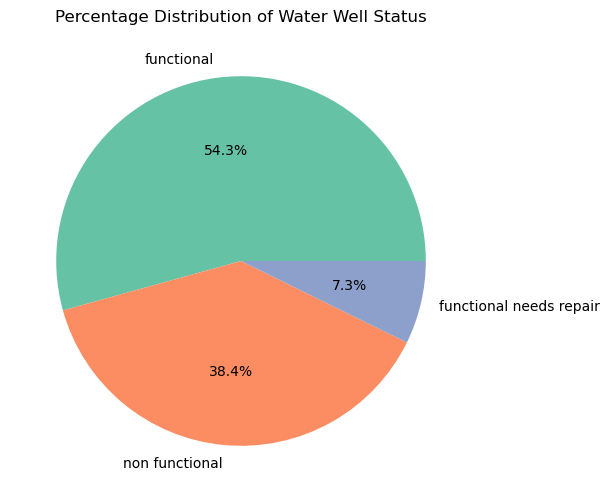

In [293]:
# Plotting a pie chart to show the distribution of well conditions

plt.figure(figsize=(8, 6))
status_counts = train_data['status_group'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=plt.get_cmap('Set2').colors)
plt.title('Percentage Distribution of Water Well Status')
plt.show()


54.3% of the Water wells are functional, 38.4% are non functional and 7.3% need repair.

### Distribution of Water Quality

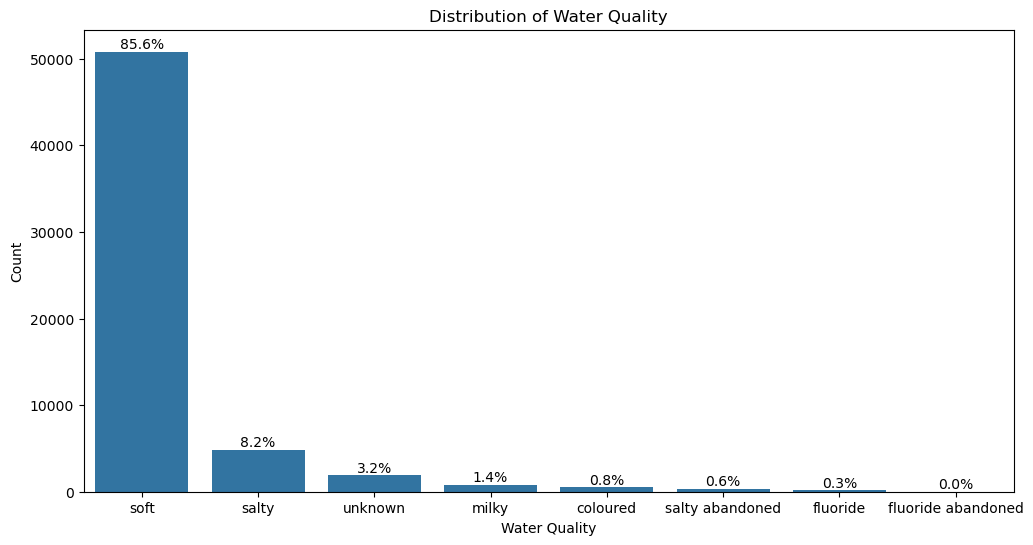

In [294]:
# Plotting the Distribution of Water Quality

# Calculate counts and sort them in descending order
water_quality_counts = train_data['water_quality'].value_counts().sort_values(ascending=False)

# Create the count plot with sorted values
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=water_quality_counts.index, y=water_quality_counts.values)

# Calculate and annotate percentages
total = len(train_data)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.title('Distribution of Water Quality')
plt.xticks(rotation=0)  # Set rotation to 0 degrees
plt.ylabel('Count')
plt.xlabel('Water Quality')
plt.show()

The ‘soft’ category has the highest count, making up approximately 85.6% of the total. This indicates that the majority of water wells in the dataset provide soft water, which is generally considered good for consumption and household use.

### Top Ten Funders

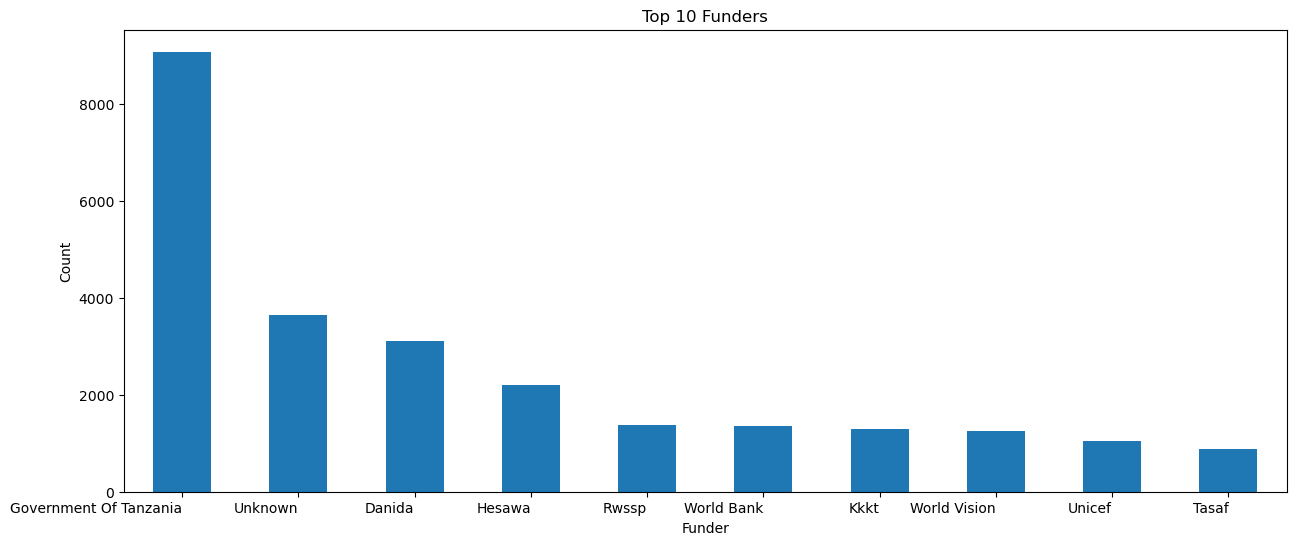

In [295]:
plt.figure(figsize=(15, 6))
train_data['funder'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Funders')
plt.xlabel('Funder')
plt.ylabel('Count')
plt.xticks(rotation = 0 , ha='right')
plt.show()

The Government of Tanzania is the leading funder, with over 8000 counts. This indicates a significant investment by the government in the projects or initiatives represented in the dataset, highlighting its commitment to development and infrastructure.

### Pump Type distribution

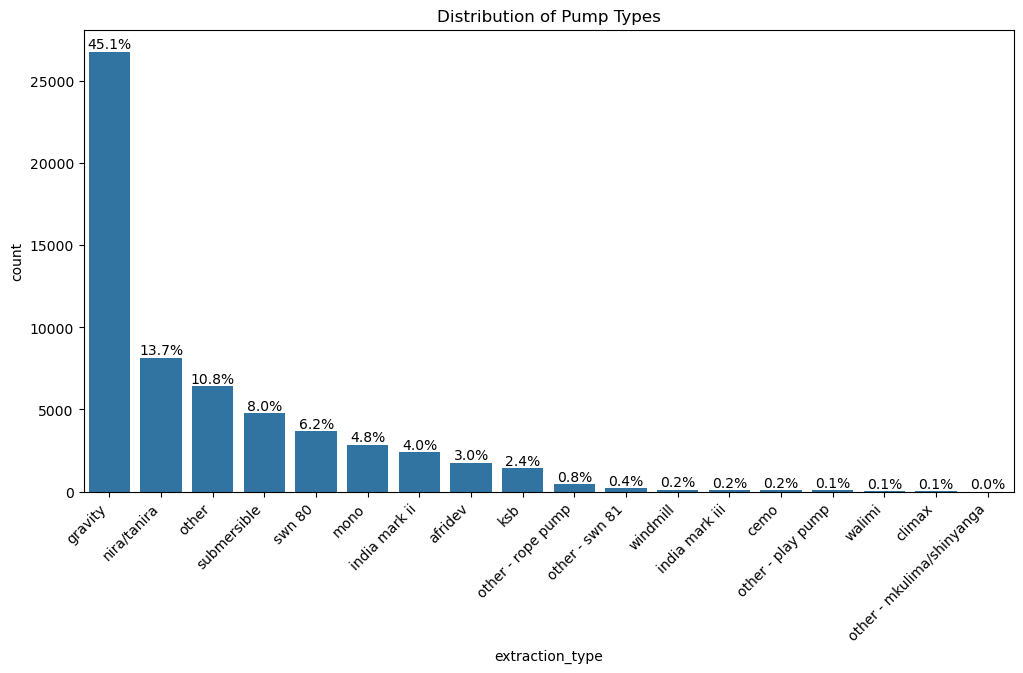

In [296]:
# Plotting the pump type distribution

# Calculate counts and sort them in ascending order
extraction_type_counts = train_data['extraction_type'].value_counts().sort_values(ascending=False)

# Create the count plot with sorted values
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='extraction_type', data=train_data, order=extraction_type_counts.index)

# Calculate and annotate percentages
total = len(train_data)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.title('Distribution of Pump Types')
plt.xticks(rotation=45, ha='right')
plt.show()

The ‘gravity’ pump type has the highest count, making up approximately 45.1% of the total. This indicates that gravity pumps are the most commonly used type in the dataset, suggesting they might be preferred due to their simplicity.

## Bivariate Analysis

The Bivariate Analysis section investigates the relationships between pairs of variables exploring how the two variables interact with each other. This analysis helps us uncover associations, trends, and dependencies that might exist between variables.

### Pump Type vs Well Condition

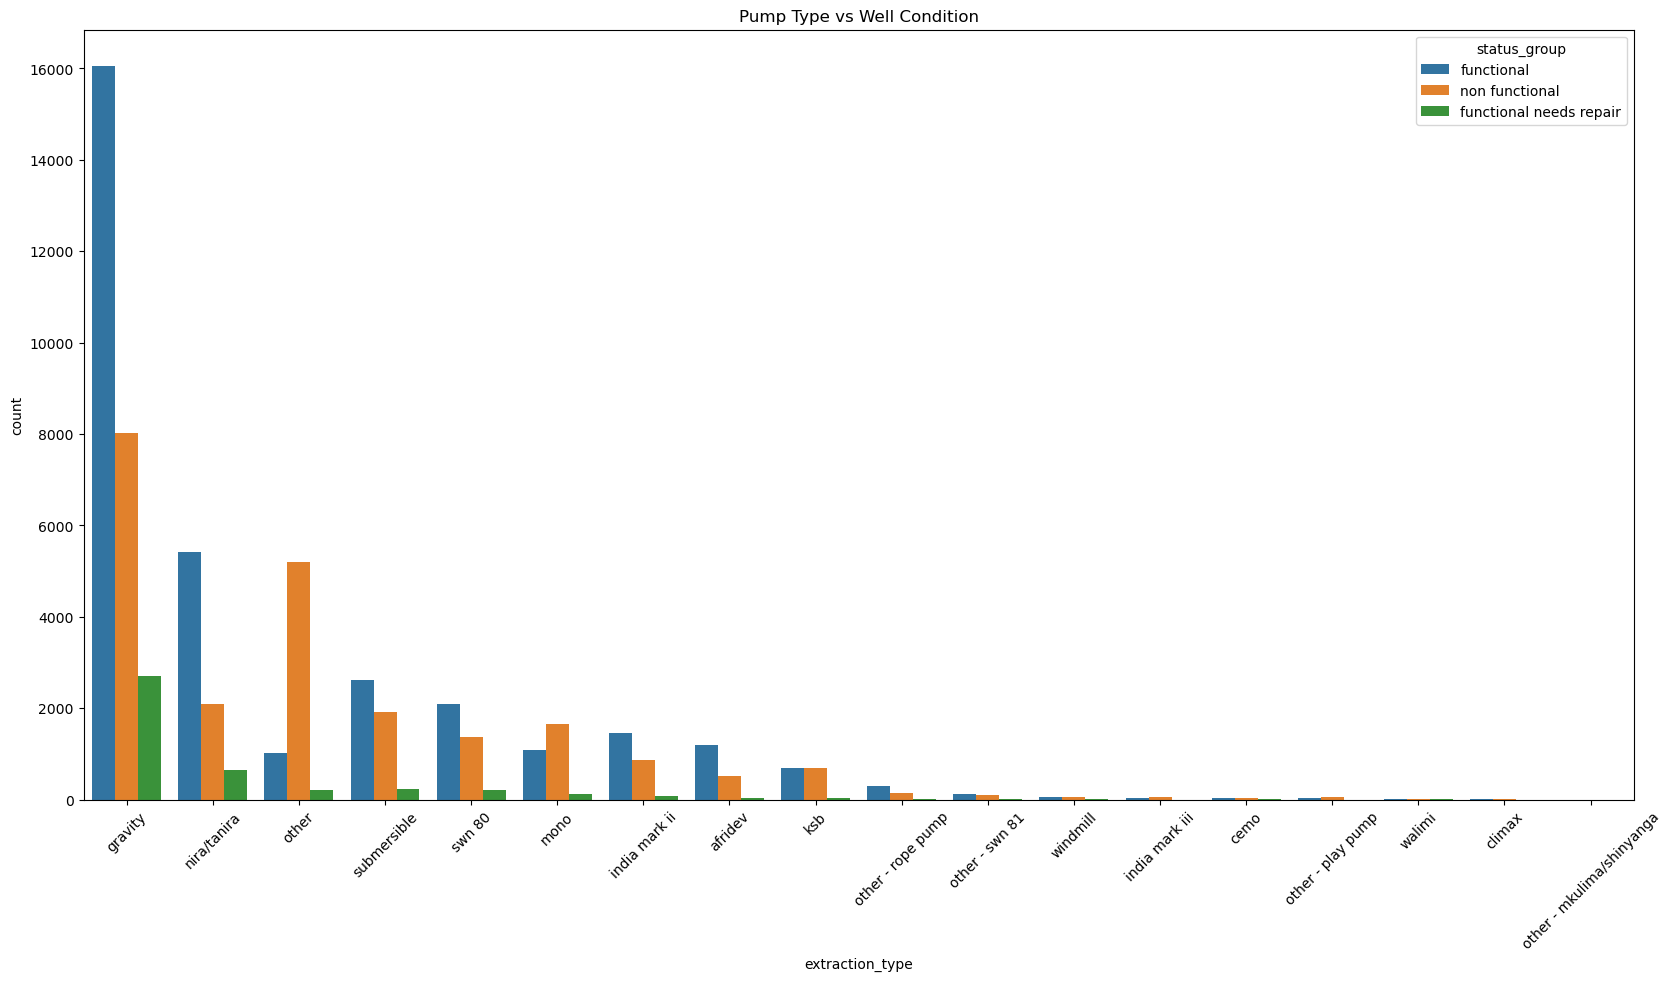

In [297]:
# Calculate counts and sort them in descending order
extraction_type_counts = train_data['extraction_type'].value_counts().sort_values(ascending=False)

# Create the count plot with sorted values
plt.figure(figsize=(20, 10))
ax = sns.countplot(x='extraction_type', hue='status_group', data=train_data, order=extraction_type_counts.index)

plt.title('Pump Type vs Well Condition')
plt.xticks(rotation= 45 )  # Rotate x-axis labels for better readability
plt.show()

The ‘gravity’ pump type has the highest count of functional wells, indicating that gravity pumps are the most reliable and widely used type in the dataset.

The ‘handpump’ and ‘submersible’ types have notable counts of non-functional wells. This suggests that these types might face more operational challenges or require more maintenance.

#### Water Quality VS Well Condition

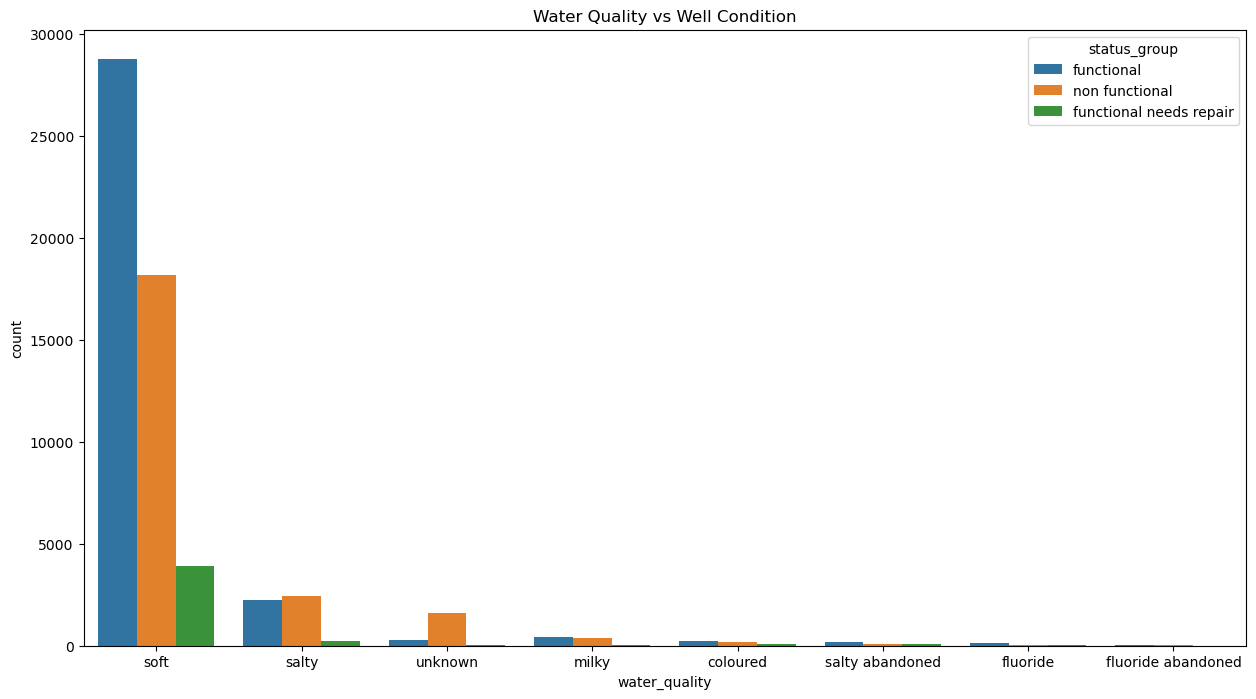

In [298]:
# Calculate counts and sort them in descending order
water_quality_counts = train_data['water_quality'].value_counts().sort_values(ascending=False)

# Create the count plot with sorted values
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='water_quality', hue='status_group', data=train_data, order=water_quality_counts.index)

plt.title('Water Quality vs Well Condition')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

The majority of functional wells have soft water quality, with counts reaching up to 30,000. This indicates that soft water is the most common and likely the most desirable water quality for functional wells.

There is a significant number of non-functional wells associated with salty and milky water quality. This suggests that these water quality issues might be contributing to the non-functionality of the wells.


#### Region Vs Well Condition

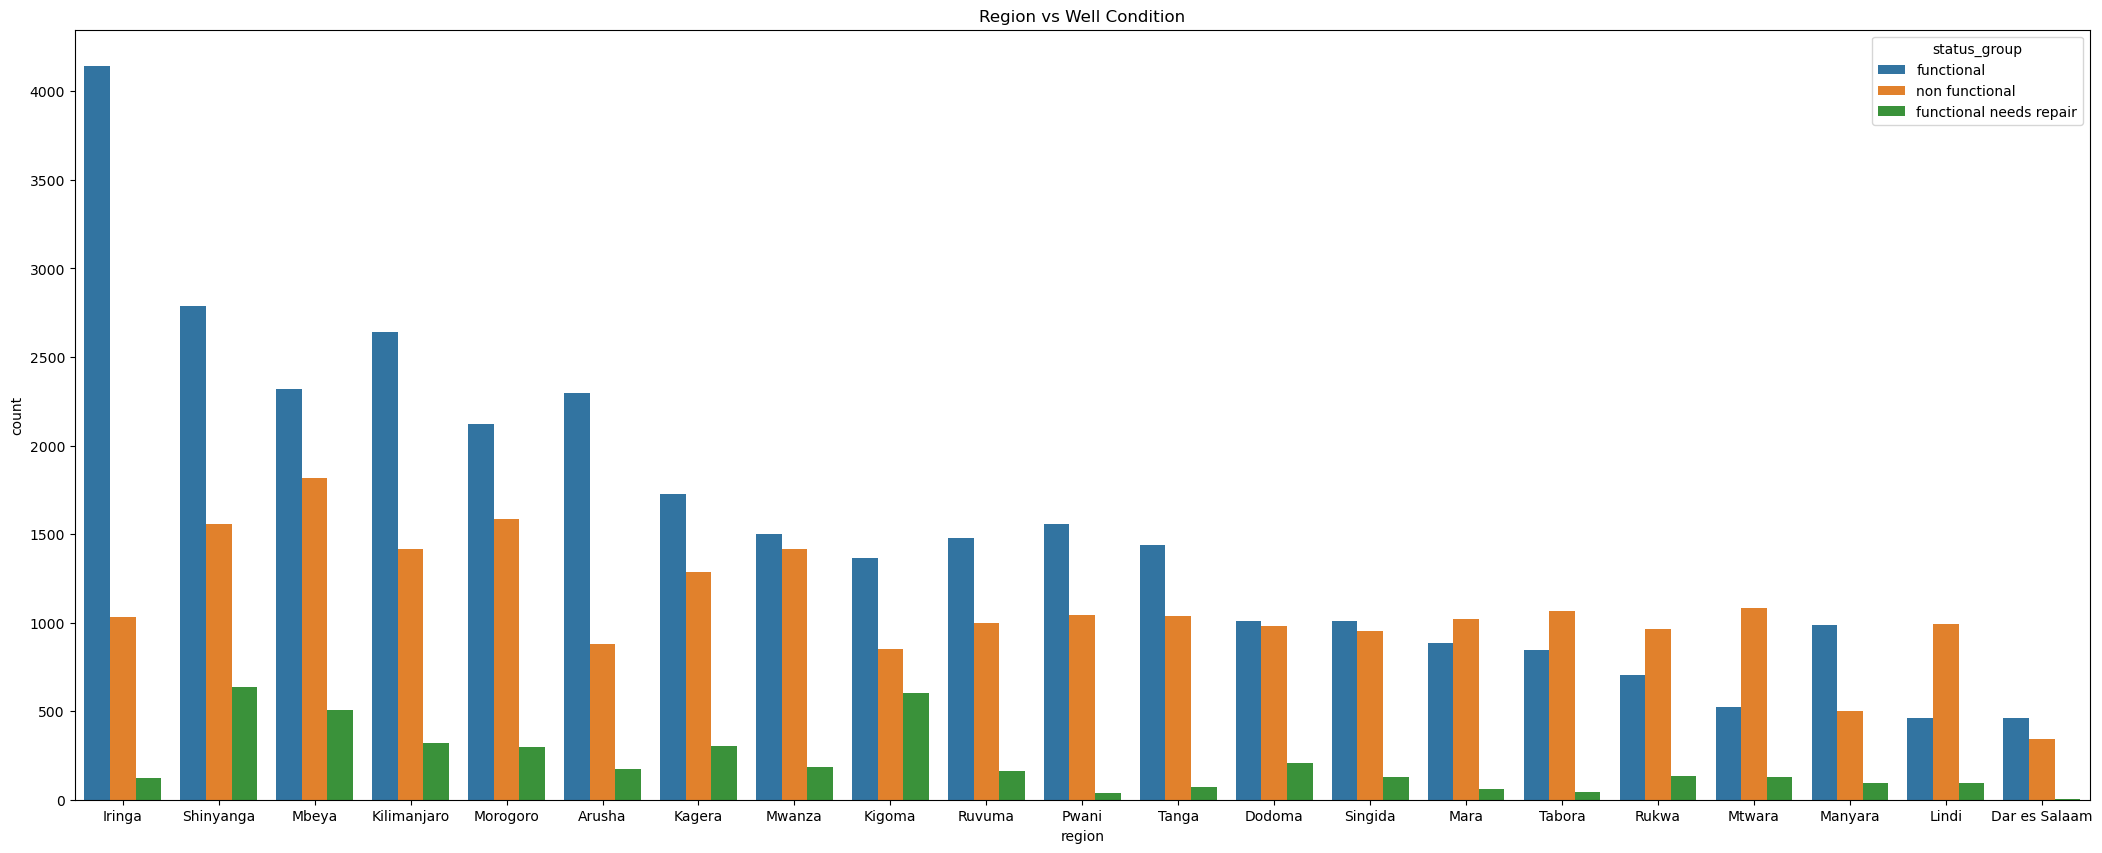

In [299]:
# Calculate counts and sort them in descending order
region_counts = train_data['region'].value_counts().sort_values(ascending=False)

# Create the count plot with sorted values
plt.figure(figsize=(26,10))
ax = sns.countplot(x='region', hue='status_group', data=train_data, order=region_counts.index)

plt.title('Region vs Well Condition')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

Regions like Dodoma and Manyara have a high number of functional wells, indicating better maintenance or more recent installations in these areas.

Regions such as Shinyanga and Mtwara have a notable number of non-functional wells. This suggests that these areas might need more attention in terms of repairs and maintenance.

## Multivariate Analysis

In the Multivariate Analysis section, we extend our examination to more than two variables simultaneously. This comprehensive approach provides deeper insights into the complex structure of our data, helping us identify patterns, correlations, and underlying factors that are crucial for building robust and accurate predictive models.

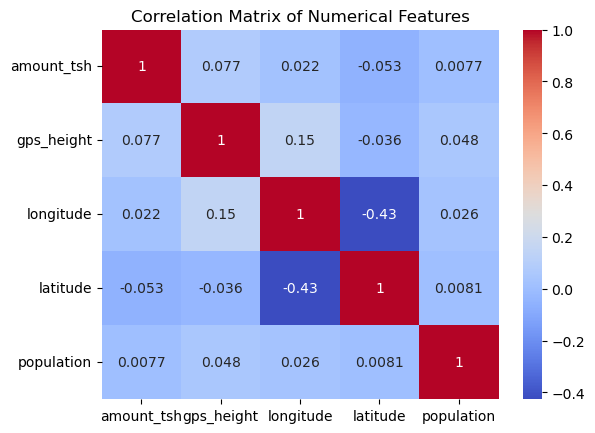

In [300]:
correlation_matrix = train_data[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Based on the correlation matrix, there are no immediate signs of high multicollinearity among the features that may affect the modelling process

# Model Training and Evaluation

## Data preprocessing

In [301]:
# Creating a copy of the original data to preserve it
data_df = train_data.copy()

#### Converting the Target variable to binary

In [302]:
# Checking the value counts of the target variable
data_df['status_group'].value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

Converting the target variable to binary where functional and functional needs repair are 1 and non functional is 0.

In [303]:
# Creating a column for the binary target. 
data_df['binary_target'] = data_df['status_group'].apply(lambda x: 1 if x in ['functional', 'functional needs repair'] else 0)
# Checking the value_counts
data_df['binary_target'].value_counts()

binary_target
1    36576
0    22824
Name: count, dtype: int64

#### Converting the permit and public meeting columns to boolean values

In [304]:
# Converting the permit and public meeting columns to boolean values
data_df[['permit','public_meeting']] = data_df[['permit','public_meeting']].astype(bool).astype(int) 

#### Selecting Features for the model

In [305]:
# Select features for the model
features = ['gps_height', 'longitude', 'latitude', 'basin', 'region', 
                'population', 'public_meeting', 'scheme_management', 'permit',
                'extraction_type', 'management', 'water_quality', 'quantity', 
                'source',]
    
X = data_df[features]
y = data_df['binary_target']

#### Scaling numerical columns and encoding categorical columns

In [306]:
# For this process we use a Robust Scaler() and WoE encoder

In [307]:
 # Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int32','int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [308]:
def preprocess_data(numeric_features, categorical_features):
    # Create preprocessing steps for numeric features
    numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

    # Create preprocessing steps for categorical features using WoE Encoder
    categorical_transformer = Pipeline(steps=[('woe', WOEEncoder(cols=categorical_features))])

    # Combine preprocessing for numeric and categorical features
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    return preprocessor

# Use the preprocessor
preprocessor = preprocess_data(numeric_features, categorical_features)


#### Splitting the data into the training and test set

In [309]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [310]:
# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

# Transform the test data
X_test_preprocessed = preprocessor.transform(X_test)

## Model Training

### Logistic Regression model

In [311]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_preprocessed, y_train)
y_pred_lr = lr_model.predict(X_test_preprocessed)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7672558922558923
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      4572
           1       0.75      0.93      0.83      7308

    accuracy                           0.77     11880
   macro avg       0.78      0.72      0.73     11880
weighted avg       0.78      0.77      0.75     11880



#### Insight
The model has a much higher recall for class 1 compared to class 0, which suggests it is better at identifying functional wells than non-functional or wells that need repair. This might be due to class imbalance or the nature of the features used.

### Decision Tree Classifier

In [312]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_preprocessed, y_train)
y_pred_dt = dt_model.predict(X_test_preprocessed)

# Evaluation
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8079124579124579
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      4572
           1       0.84      0.84      0.84      7308

    accuracy                           0.81     11880
   macro avg       0.80      0.80      0.80     11880
weighted avg       0.81      0.81      0.81     11880



#### Insight
The Decision Tree model provides a more balanced performance across both classes compared to the Logistic Regression model. It has similar precision and recall for both class 0 and class 1, which indicates that the model is not biased towards one class over the other.

### EXtra Trees Classifier

In [313]:
# Extra Trees
et_model = ExtraTreesClassifier(random_state=42)
et_model.fit(X_train_preprocessed, y_train)
y_pred_et = et_model.predict(X_test_preprocessed)

# Evaluation
print("Extra Trees Accuracy:", accuracy_score(y_test, y_pred_et))
print(classification_report(y_test, y_pred_et))

Extra Trees Accuracy: 0.8391414141414142
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      4572
           1       0.85      0.89      0.87      7308

    accuracy                           0.84     11880
   macro avg       0.83      0.82      0.83     11880
weighted avg       0.84      0.84      0.84     11880



#### Insights
Improved Performance: The Extra Trees model outperforms both the Logistic Regression and Decision Tree models, particularly in terms of accuracy and F1-scores. 

Class Balance: The model exhibits a good balance between precision and recall for both classes, which is critical in ensuring that neither functional nor non-functional/repair-needed wells are disproportionately misclassified.

### Random Forest Classifier

In [314]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_preprocessed, y_train)
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8488215488215488
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      4572
           1       0.86      0.91      0.88      7308

    accuracy                           0.85     11880
   macro avg       0.85      0.83      0.84     11880
weighted avg       0.85      0.85      0.85     11880



#### Insights
Strong Performance: The Random Forest model shows slightly better performance than the Extra Trees model in terms of accuracy and F1-scores.

Class Balance: The model exhibits a good balance between precision and recall for both classes, particularly for class 1 (functional wells), where it excels with a high recall and F1-score.

### XGBoost

In [315]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)
y_pred_xgb = xgb_model.predict(X_test_preprocessed)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8313131313131313
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      4572
           1       0.82      0.93      0.87      7308

    accuracy                           0.83     11880
   macro avg       0.84      0.80      0.81     11880
weighted avg       0.83      0.83      0.83     11880



#### Insight
The model is very precise in predicting class 0 wells but has a lower recall, meaning it is more likely to miss non-functional or repair-needed wells. This could be due to the model favoring class 1 wells, which is reflected in the higher recall for class 1.

Strong Performance for Class 1: The model performs excellently in detecting functional wells, with both high precision and recall, resulting in a strong F1-score of 0.87 for class 1.

Overall Performance: The XGBoost model shows strong overall performance, but the lower recall for class 0 suggests that the model might not be as balanced  as Random Forest.

### K-Nearest Neighbors

In [316]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_preprocessed, y_train)
y_pred_knn = knn_model.predict(X_test_preprocessed)

# Evaluation
print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Accuracy: 0.8102693602693603
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      4572
           1       0.82      0.88      0.85      7308

    accuracy                           0.81     11880
   macro avg       0.80      0.79      0.79     11880
weighted avg       0.81      0.81      0.81     11880



The model performs well in predicting functional wells (class 1), with high precision and recall, resulting in a strong F1-score of 0.85.

Lower Recall for Class 0: The model struggles a bit more with identifying non-functional or repair-needed wells (class 0), as reflected by a lower recall of 0.69. This suggests that the model tends to classify some non-functional wells as functional.

Overall Performance: The KNN model performs solidly, but it is not as strong as some of the other models, such as Random Forest or XGBoost, particularly in terms of recall for class 0.

In [317]:
# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_preprocessed, y_train)
y_pred_lgb = lgb_model.predict(X_test_preprocessed)

# Evaluation
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 29268, number of negative: 18252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615909 -> initscore=0.472220
[LightGBM] [Info] Start training from score 0.472220
LightGBM Accuracy: 0.8122895622895623
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      4572
           1       0.79      0.94      0.86      7308

    accuracy                           0.81     11880
   macro avg       0.83      0.77      0.79     11880
weighted avg       0.82      0.81      0.80     11880



#### Insight
 The model is very precise in predicting non-functional or repair-needed wells but has a lower recall, meaning it tends to miss a significant portion of these wells. This could result in a higher false-negative rate, where non-functional wells are classified as functional.

### Model Selection 

In [318]:
# Initialize an empty list to store the results
results = []

# Define a function to evaluate a model and store the results
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Creating a dictionary with the models
models = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Extra Trees': et_model,
    'Random Forest': rf_model,
       'XGBoost': xgb_model,
    'K-Nearest Neighbors': knn_model,
    'LightGBM': lgb_model
}

# Evaluate each model and store the results
for model_name, model in models.items():
    evaluate_model(model_name, model, X_test_preprocessed, y_test)

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Sort the DataFrame by Accuracy
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)

# Display the results DataFrame
results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
3,Random Forest,0.848822,0.855246,0.907909,0.880791,0.910436
2,Extra Trees,0.839141,0.854087,0.890668,0.871994,0.902317
4,XGBoost,0.831313,0.820135,0.929666,0.871473,0.896918
6,LightGBM,0.812290,0.791504,0.943350,0.860782,0.881959
5,K-Nearest Neighbors,0.810269,0.821665,0.883279,0.851358,0.864357
1,Decision Tree,0.807912,0.843119,0.844964,0.844040,0.795651
0,Logistic Regression,0.767256,0.751523,0.928708,0.830773,0.802277


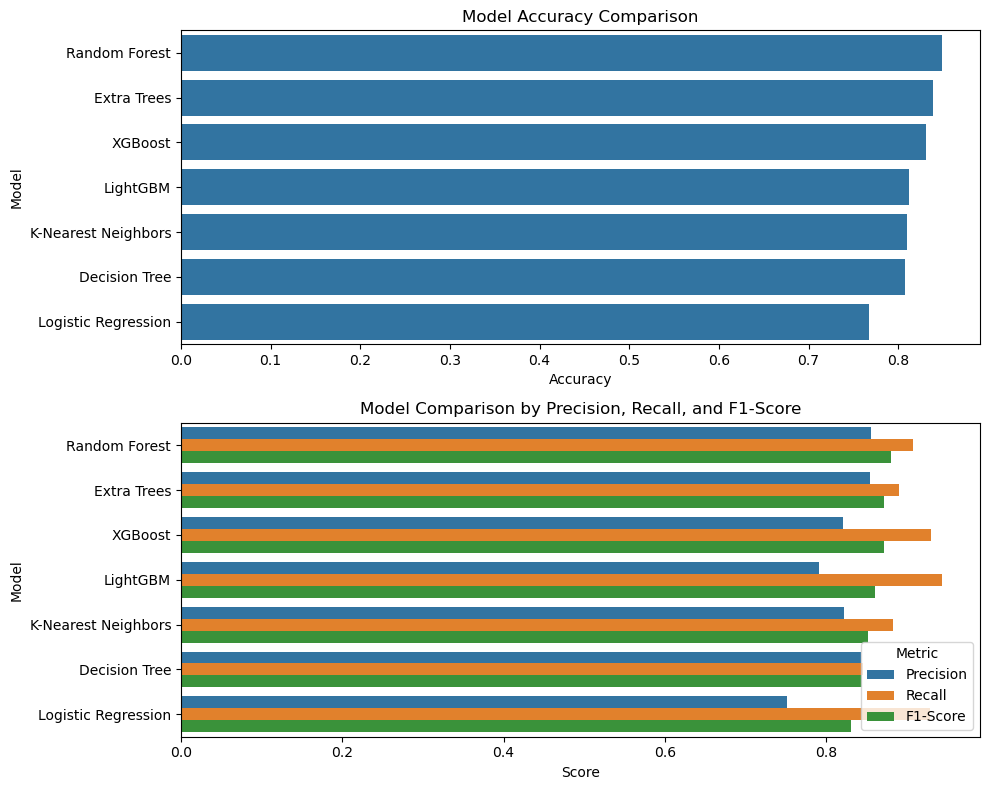

In [319]:
# DataFrame for Precision, Recall, and F1-Score
metrics_df = results_df.melt(id_vars='Model', value_vars=['Precision', 'Recall', 'F1-Score'], 
                             var_name='Metric', value_name='Score')

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

# Plot Accuracy
sns.barplot(x='Accuracy', y='Model', data=results_df, ax=axes[0])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Model')

# Plot Precision, Recall, and F1-Score with different colors
sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_df, ax=axes[1])

axes[1].set_title('Model Comparison by Precision, Recall, and F1-Score')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Model')

# Add legend
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, title='Metric')

# Display the plots
plt.tight_layout()
plt.show()

Random Forest is considered the best model in this context because it performs exceptionally well across several key evaluation metrics:

1. High Accuracy (0.848822):
Random Forest has the highest accuracy among all the models, indicating that it consistently makes the correct predictions for both classes (functional and non-functional wells).

2. Balanced Precision (0.855246) and Recall (0.907909):
A precision of 0.855246 suggests that the model has a low rate of false positives, meaning it's good at not falsely predicting wells as functional when they are not.
With a recall of 0.907909, Random Forest is excellent at detecting nearly all functional wells, minimizing false negatives.

3. High F1-Score (0.880791):
A high F1-score of 0.880791 suggests that Random Forest excels in both accurately predicting functional wells and identifying them correctly.

4. Top ROC-AUC (0.910436):
. A ROC-AUC of 0.910436 indicates that Random Forest is highly effective at separating the two classes, meaning it is very reliable in distinguishing between functional and non-functional wells.


## Evaluation of selected model

Random Forest Accuracy: 0.8488215488215488
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      4572
           1       0.86      0.91      0.88      7308

    accuracy                           0.85     11880
   macro avg       0.85      0.83      0.84     11880
weighted avg       0.85      0.85      0.85     11880

Confusion Matrix:
 [[3449 1123]
 [ 673 6635]]


<Figure size 800x600 with 0 Axes>

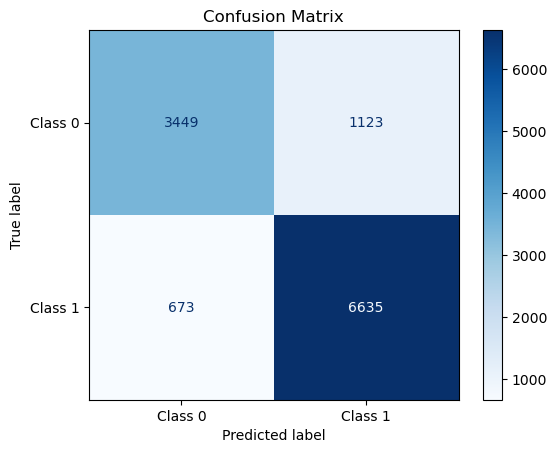

In [320]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_preprocessed, y_train)
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Class 0', 'Class 1'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')  # Use 'd' for integer values

plt.title('Confusion Matrix')
plt.show();

####  Insights

The model excels at predicting functional wells (Class 1) with a high recall of 91% and precision of 86%. This is critical for ensuring that functional wells are correctly identified, which can be crucial for prioritizing resources.
Lower Performance in Identifying Non-Functional Wells (Class 0):

The model has lower recall for non-functional wells (Class 0) at 75%. This means some non-functional wells are not being identified correctly. Addressing this might involve further tuning of the model or adjusting class weights to improve performance on this class.
Trade-Off Between Precision and Recall:

The high accuracy and balanced weighted averages suggest that the model is generally robust and performs well across the dataset, despite the imbalance in class distribution.

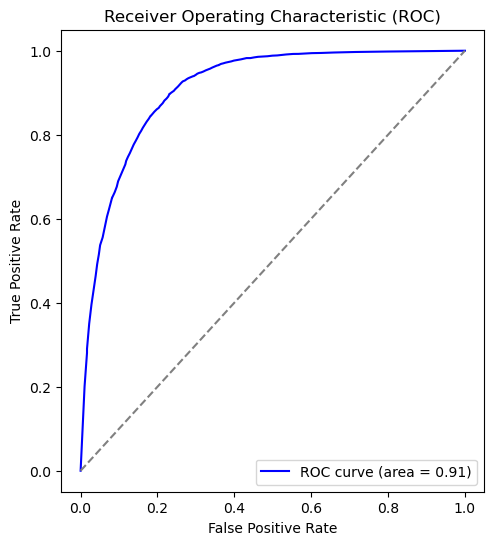

In [321]:
# ROC Curve and AUC
y_prob_rf = rf_model.predict_proba(X_test_preprocessed)[:, 1]  # Probability estimates for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

The high AUC value suggests that the model has strong predictive power and is effective at distinguishing between functional and non-functional wells.
Model Reliability:


## Tuning of the model to improve performance

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.8486321548821548
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      4572
           1       0.85      0.93      0.88      7308

    accuracy                           0.85     11880
   macro avg       0.85      0.83      0.84     11880
weighted avg       0.85      0.85      0.85     11880



<Figure size 800x600 with 0 Axes>

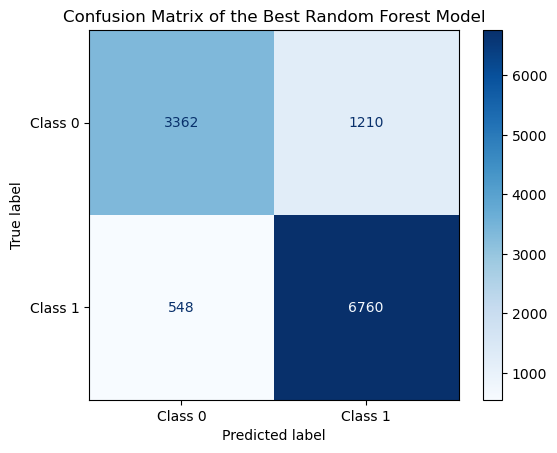

In [322]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit Grid Search to the data
grid_search.fit(X_train_preprocessed, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

# Print classification report
print(classification_report(y_test, y_pred_best_rf))

# Compute and plot the confusion matrix

conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
disp_best_rf = ConfusionMatrixDisplay(conf_matrix_best_rf, display_labels=['Class 0', 'Class 1'])

plt.figure(figsize=(8, 6))
disp_best_rf.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of the Best Random Forest Model')
plt.show()

#### Insight
The new model with grid search has slightly improved precision for Class 0 and recall for Class 1. However, the overall accuracy and F1-Scores have not changed.

The slight decrease in recall for Class 0 might be a trade-off for the improved precision for Class 0, while the increase in recall for Class 1 is beneficial.

# Feature Importance Analysis

Tree-based models like Random Forest, Extra Trees, XGBoost, and LightGBM can provide insights into feature importance based on their internal algorithms. This section extracts and visualizes the importance of different features as determined by these models, highlighting which features most influence predictions.

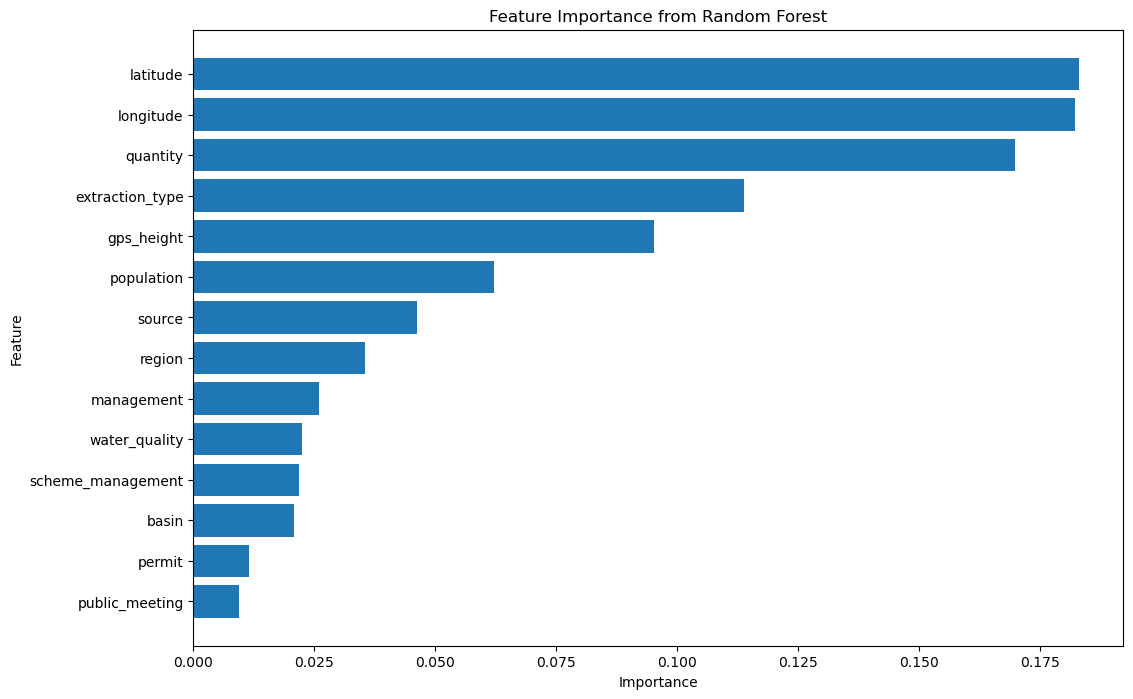

In [323]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = (list(numeric_features) + 
                 list(preprocessor.named_transformers_['cat'].named_steps['woe'].get_feature_names_out()))
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Findings

1. High number of functional wells in regions like Dodoma and Manyara.
2. Significant non-functional wells in regions like Shinyanga and Mtwara.
3. Majority of functional wells have soft water quality.
4. Gravity pumps have the highest count of functional wells.
5. Handpumps and submersible pumps have notable counts of non-functional wells.


# Recommendations
1. Focus maintenance efforts on regions with high numbers of non-functional wells (e.g., Shinyanga and Mtwara).
2. Consider the high reliability of gravity pumps and the challenges faced by handpumps and submersible pumps.
3. Address water quality issues in regions with non-functional wells, especially those with salty and milky water.
4. Implement water treatment solutions or alternative water sources.
5. Map the distribution of well conditions and pump types to identify regional patterns.
6. Analyze changes in well conditions over time to assess the effectiveness of past interventions.
7. Work with NGOs and government agencies to implement targeted interventions based on model predictions.
